<a href="https://colab.research.google.com/github/mihirn07/BTP/blob/main/transfer_learning_btp_model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 30.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import os
import json
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast, AutoTokenizer 
from mpl_toolkits import mplot3d
%matplotlib inline
import matplotlib.pyplot as plt
# specify GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/btp_data/data'
files = os.listdir(path)

In [ ]:
data = pd.read_csv(path + '/' + files[0])

for i in range(1,len(files)):
  data = pd.concat([data, pd.read_csv(path + '/' + files[i])])

In [ ]:
data

,Unnamed: 0,sentence,tag
0,1,Figure 1a shows that theaverage (mean: 72.09 ±...,0
1,2,The maximum concentration was 164.93 μgm−3 dur...,0
2,3,The time series plot(Figure 1b) presents the d...,0
3,4,"Out of 64 days, 7 dayscross the CPCB-permissib...",0
4,5,The box whisker plot (Figure1c) indicates a de...,0
...,...,...,...
279,279,"A recent work by Goel et al., (2021), discusse...",1
280,280,The original work pro-posing double-PMF (Petit...,0
281,281,"However, in case of the present study we note ...",0
282,282,Since the PMF technique is limited in its abil...,0


In [ ]:
data['tag'].value_counts()

0    545
1    430
Name: tag, dtype: int64

In [ ]:
train_text, test_text, train_labels, test_labels = train_test_split(data['sentence'], data['tag'], random_state=16, test_size=0.3, stratify=data['tag'])

In [ ]:
'''# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased', output_attentions = True)

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')'''


tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
bert = AutoModel.from_pretrained('allenai/scibert_scivocab_uncased')

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<Axes: >

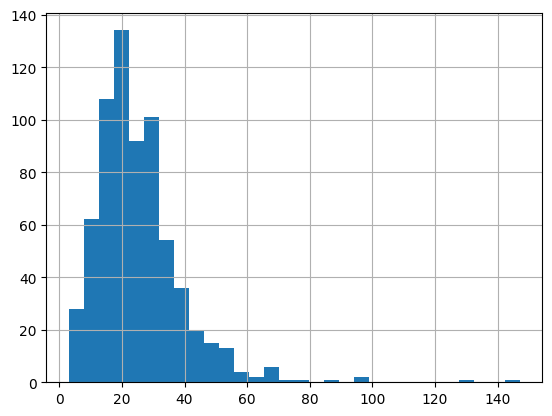

In [ ]:
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
max_seq_len = 100

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
len(tokens_train['input_ids'][0])

100

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [ ]:
bert_params = []
for name, param in bert.named_parameters():
     print(name, param.requires_grad)
     bert_params.append(name)

embeddings.word_embeddings.weight True
embeddings.position_embeddings.weight True
embeddings.token_type_embeddings.weight True
embeddings.LayerNorm.weight True
embeddings.LayerNorm.bias True
encoder.layer.0.attention.self.query.weight True
encoder.layer.0.attention.self.query.bias True
encoder.layer.0.attention.self.key.weight True
encoder.layer.0.attention.self.key.bias True
encoder.layer.0.attention.self.value.weight True
encoder.layer.0.attention.self.value.bias True
encoder.layer.0.attention.output.dense.weight True
encoder.layer.0.attention.output.dense.bias True
encoder.layer.0.attention.output.LayerNorm.weight True
encoder.layer.0.attention.output.LayerNorm.bias True
encoder.layer.0.intermediate.dense.weight True
encoder.layer.0.intermediate.dense.bias True
encoder.layer.0.output.dense.weight True
encoder.layer.0.output.dense.bias True
encoder.layer.0.output.LayerNorm.weight True
encoder.layer.0.output.LayerNorm.bias True
encoder.layer.1.attention.self.query.weight True
encoder.

In [ ]:
to_be_finetuned = bert_params[len(bert_params)-34:len(bert_params)]

In [ ]:
'''# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False'''
  
for name, param in bert.named_parameters():
    if name in to_be_finetuned:
      param.requires_grad = True

In [ ]:
for name, param in bert.named_parameters():
  print(name, param.requires_grad)

embeddings.word_embeddings.weight False
embeddings.position_embeddings.weight False
embeddings.token_type_embeddings.weight False
embeddings.LayerNorm.weight False
embeddings.LayerNorm.bias False
encoder.layer.0.attention.self.query.weight False
encoder.layer.0.attention.self.query.bias False
encoder.layer.0.attention.self.key.weight False
encoder.layer.0.attention.self.key.bias False
encoder.layer.0.attention.self.value.weight False
encoder.layer.0.attention.self.value.bias False
encoder.layer.0.attention.output.dense.weight False
encoder.layer.0.attention.output.dense.bias False
encoder.layer.0.attention.output.LayerNorm.weight False
encoder.layer.0.attention.output.LayerNorm.bias False
encoder.layer.0.intermediate.dense.weight False
encoder.layer.0.intermediate.dense.bias False
encoder.layer.0.output.dense.weight False
encoder.layer.0.output.dense.bias False
encoder.layer.0.output.LayerNorm.weight False
encoder.layer.0.output.LayerNorm.bias False
encoder.layer.1.attention.self.query

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      self.dropout = nn.Dropout(0.1)
      self.relu =  nn.ReLU()
      self.fc1 = nn.Linear(768,512)
      self.fc2 = nn.Linear(512,2)
      self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask = torch.tensor([0])):


      cls_hs = self.bert(sent_id, attention_mask=mask)[1]
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)
      x = self.softmax(x)

      return x

In [ ]:
model = BERT_Arch(bert)
model = model.to(device)

In [ ]:
for name, param in model.named_parameters():
  if str(name).startswith('bert'):
    param.requires_grad = False

In [ ]:
for name, param in model.named_parameters():
  print(name, param.requires_grad)

bert.embeddings.word_embeddings.weight False
bert.embeddings.position_embeddings.weight False
bert.embeddings.token_type_embeddings.weight False
bert.embeddings.LayerNorm.weight False
bert.embeddings.LayerNorm.bias False
bert.encoder.layer.0.attention.self.query.weight False
bert.encoder.layer.0.attention.self.query.bias False
bert.encoder.layer.0.attention.self.key.weight False
bert.encoder.layer.0.attention.self.key.bias False
bert.encoder.layer.0.attention.self.value.weight False
bert.encoder.layer.0.attention.self.value.bias False
bert.encoder.layer.0.attention.output.dense.weight False
bert.encoder.layer.0.attention.output.dense.bias False
bert.encoder.layer.0.attention.output.LayerNorm.weight False
bert.encoder.layer.0.attention.output.LayerNorm.bias False
bert.encoder.layer.0.intermediate.dense.weight False
bert.encoder.layer.0.intermediate.dense.bias False
bert.encoder.layer.0.output.dense.weight False
bert.encoder.layer.0.output.dense.bias False
bert.encoder.layer.0.output.Lay

In [ ]:
type(name)

str

In [ ]:
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 2e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
model.parameters

<bound method Module.parameters of BERT_Arch(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((76

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_labels), y = train_labels)

print(class_wts)

[0.89501312 1.13289037]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 5

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 5 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# empty lists to store training and validation loss of each epoch
train_losses = []

In [ ]:
#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    #train model
    train_loss, b = train()
    print(f'\nTraining Loss: {train_loss:.3f}')
    torch.save(model.state_dict(), '/content/drive/MyDrive/btp_data/btp_model_scibert_fintune_weights.pt')
    # append training and validation loss
    train_losses.append(train_loss)


 Epoch 1 / 5
  Batch     5  of     22.
  Batch    10  of     22.
  Batch    15  of     22.
  Batch    20  of     22.

Training Loss: 0.484

 Epoch 2 / 5
  Batch     5  of     22.
  Batch    10  of     22.
  Batch    15  of     22.
  Batch    20  of     22.

Training Loss: 0.463

 Epoch 3 / 5
  Batch     5  of     22.
  Batch    10  of     22.
  Batch    15  of     22.
  Batch    20  of     22.

Training Loss: 0.410

 Epoch 4 / 5
  Batch     5  of     22.
  Batch    10  of     22.
  Batch    15  of     22.
  Batch    20  of     22.

Training Loss: 0.406

 Epoch 5 / 5
  Batch     5  of     22.
  Batch    10  of     22.
  Batch    15  of     22.
  Batch    20  of     22.

Training Loss: 0.348


In [ ]:
#load weights of best model
path = '/content/drive/MyDrive/btp_data/btp_model_scibert_fintune_weights.pt'
model.load_state_dict(torch.load(path, map_location = 'cpu')) #map_location = 'cpu' when not on GPU

<All keys matched successfully>

In [ ]:
len(train_losses)

25

In [ ]:
epochs

5

In [ ]:
lis_epoch = list(range(1,epochs+20+1))
imp_lists = {'lis_epoch' : lis_epoch, 'train_losses': train_losses}
torch.save(imp_lists, '/content/drive/MyDrive/btp_data/f_scibert')

In [ ]:
loaded = torch.load('/content/drive/MyDrive/btp_data/f_scibert', map_location = 'cpu')
lis_epoch = loaded['lis_epoch']
train_losses = loaded['train_losses']

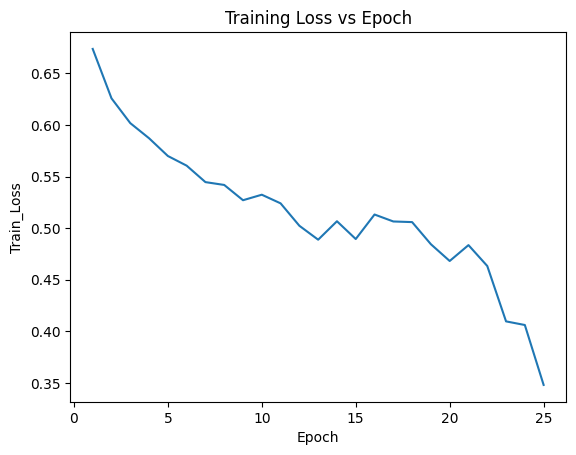

In [ ]:
plt.plot(lis_epoch, train_losses)
plt.xlabel("Epoch")  # add X-axis label
plt.ylabel("Train_Loss")  # add Y-axis label
plt.title("Training Loss vs Epoch")  # add title
plt.show()

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
pred_func = torch.nn.Softmax(dim=1)
ans = pred_func(torch.tensor(preds))
ans1  = torch.max(ans,1)
pred = ans1.values
pred_ind = ans1.indices

In [ ]:
# 0 is Unimportant, 1 is Important
#preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, pred_ind))

              precision    recall  f1-score   support

           0       0.79      0.80      0.79       164
           1       0.74      0.73      0.73       129

    accuracy                           0.77       293
   macro avg       0.76      0.76      0.76       293
weighted avg       0.77      0.77      0.77       293



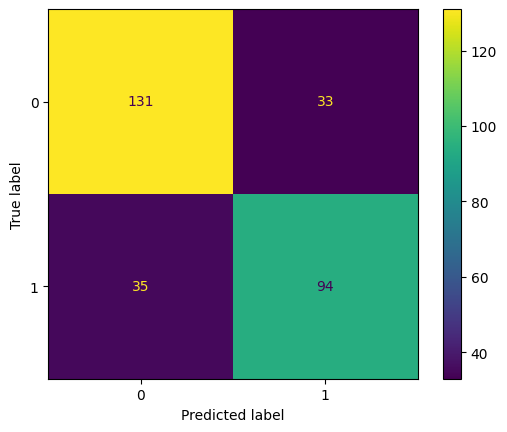

In [ ]:
import sklearn
disp = sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(test_y, pred_ind))
disp.plot()

In [ ]:
x = 'papers/paper1.pdf'

In [ ]:
x[7:-4]

'paper1'